In [2]:
# ==============================================================================
# CELL 1: LOAD PREPARED DATASETS
# ==============================================================================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load all the arrays from the .npz file
data = np.load('normalized_split_data.npz')

# Assign them to the correct variables
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

print("--- Data Loaded Successfully ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"X_test shape:  {X_test.shape}")

--- Data Loaded Successfully ---
X_train shape: (313480, 50, 3)
X_val shape:   (188088, 50, 3)
X_test shape:  (125393, 50, 3)


In [3]:
# ==============================================================================
# CELL 5: BUILD THE CNN-BiLSTM FUSION MODEL
# ==============================================================================
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_cnn_bilstm_model(input_shape):
    inp = layers.Input(shape=input_shape)

    # --- Part 1: CNN Feature Extractor (Same as before) ---
    x = layers.Conv1D(128, kernel_size=5, padding="same", activation="elu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, kernel_size=5, padding="same", activation="elu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(256, kernel_size=3, padding="same", activation="elu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(256, kernel_size=3, padding="same", activation="elu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # --- Part 2: BiLSTM Context Expert (The NEW Part) ---
    # The Bidirectional wrapper allows the LSTM to learn from the sequence forwards and backwards.
    x = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(units=64))(x) # You can stack LSTMs

    # --- Part 3: Decision-Making Head (Slightly modified) ---
    x = layers.Dense(256, activation="elu")(x)
    x = layers.Dropout(0.3)(x) # Slightly increased dropout for this more complex model
    x = layers.Dense(128, activation="elu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="linear")(x)

    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])
    return model

# This assumes X_train is already created and normalized from the previous steps
input_shape = (X_train.shape[1], X_train.shape[2])
hybrid_model = build_cnn_bilstm_model(input_shape)

print("--- CNN-BiLSTM Fusion Model Built Successfully ---")
hybrid_model.summary()

--- CNN-BiLSTM Fusion Model Built Successfully ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 128)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 25, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 25, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 12, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,007,233 (3.84 MB)

 Trainable params: 1,005,697 (3.84 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [4]:
# ==============================================================================
# CELL 6: TRAIN AND EVALUATE THE FUSION MODEL
# ==============================================================================

print("\n--- Starting CNN-BiLSTM Model Training ---")

# We can reuse the same callbacks
early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history_hybrid = hybrid_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Save the new, more powerful model
hybrid_model.save('soc_cnn_bilstm_model.keras')
print("\n--- Fusion model training complete and model saved as 'soc_cnn_bilstm_model.keras' ---")

# Final evaluation on the test set
test_loss, test_mae = hybrid_model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Set Performance (CNN-BiLSTM Model):")
print(f" -> Mean Squared Error (MSE): {test_loss:.5f}")
print(f" -> Mean Absolute Error (MAE): {test_mae:.5f}  (or {test_mae*100:.3f}%)")


--- Starting CNN-BiLSTM Model Training ---
Epoch 1/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 330s 263ms/step - loss: 0.0112 - mae: 0.0732 - val_loss: 0.0049 - val_mae: 0.0501 - learning_rate: 0.0010
Epoch 2/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 269s 219ms/step - loss: 0.0052 - mae: 0.0532 - val_loss: 0.0042 - val_mae: 0.0463 - learning_rate: 0.0010
Epoch 3/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 278s 227ms/step - loss: 0.0042 - mae: 0.0472 - val_loss: 0.0046 - val_mae: 0.0494 - learning_rate: 0.0010
Epoch 4/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 265s 216ms/step - loss: 0.0036 - mae: 0.0432 - val_loss: 0.0026 - val_mae: 0.0352 - learning_rate: 0.0010
Epoch 5/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 263s 215ms/step - loss: 0.0031 - mae: 0.0398 - val_loss: 0.0030 - val_mae: 0.0396 - learning_rate: 0.0010
Epoch 6/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 267s 218ms/step - loss: 0.0027 - mae: 0.0367 - val_loss: 0.0026 - val_mae: 0.0340 - learning_rate: 0.0010
Epoch 7/100
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 272s 222ms/step - l


--- Visualizing Learning Curves for CNN-BiLSTM Model ---


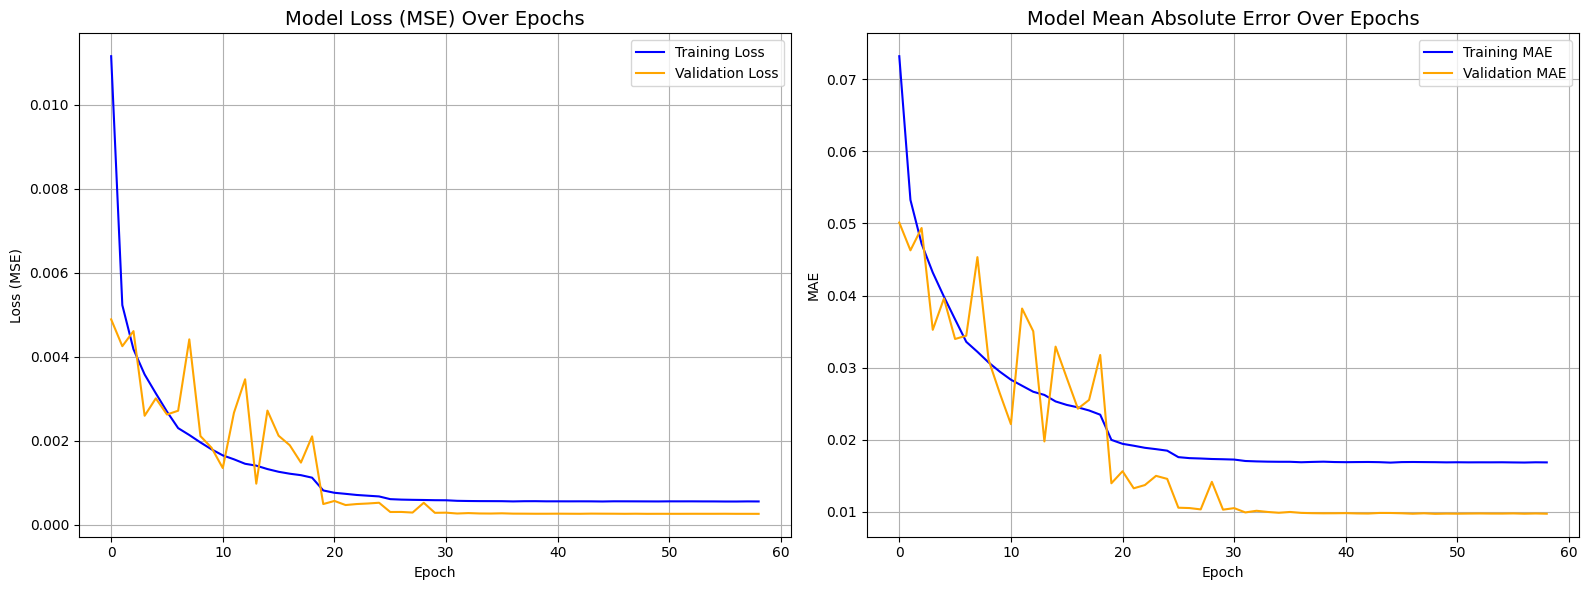

In [5]:
import matplotlib.pyplot as plt

# Assuming 'history_hybrid' is the variable holding the history object from your model.fit() call.
# If you used a different name, replace 'history_hybrid' with that name.

print("\n--- Visualizing Learning Curves for CNN-BiLSTM Model ---")

plt.figure(figsize=(16, 6))

# Plot 1: Model Loss (MSE) over Epochs
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(history_hybrid.history['loss'], label='Training Loss', color='blue')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss (MSE) Over Epochs', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot 2: Model Mean Absolute Error (MAE) over Epochs
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(history_hybrid.history['mae'], label='Training MAE', color='blue')
plt.plot(history_hybrid.history['val_mae'], label='Validation MAE', color='orange')
plt.title('Model Mean Absolute Error Over Epochs', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjusts plot parameters for a tight layout
plt.show()

--- Loading saved model... ---
--- Loading test data... ---
-> Model and data loaded successfully.
3919/3919 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step

--- Generating Plots ---


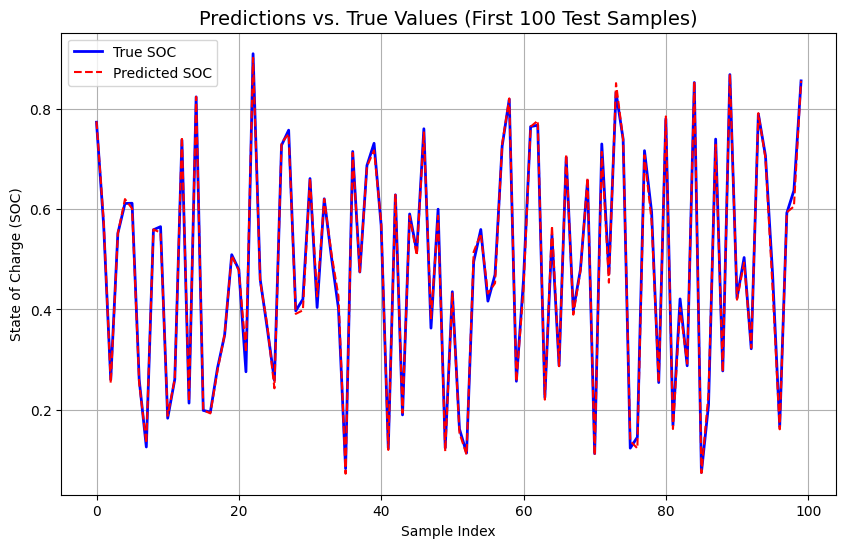


--- Final Model Performance Metrics on Test Set ---
Mean Absolute Error (MAE):      0.0098  (or 0.98%)
Root Mean Squared Error (RMSE): 0.0160
R-squared (R²) Score:         0.9950
Correlation Coefficient (Corr): 0.9975


In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ==============================================================================
# STEP 1: LOAD THE SAVED MODEL AND TEST DATA
# ==============================================================================

# Load the trained model from the file
print("--- Loading saved model... ---")
model = load_model('soc_cnn_bilstm_model.keras')

# Load the test data from the .npz file
print("--- Loading test data... ---")
data = np.load('normalized_split_data.npz')
X_test = data['X_test']
y_test = data['y_test']

print("-> Model and data loaded successfully.")


# ==============================================================================
# STEP 2: MAKE PREDICTIONS AND VISUALIZE RESULTS
# ==============================================================================

# Generate predictions on the test set
y_pred = model.predict(X_test)

# --- Create the Predictions vs. True Values Plot (100 Samples) ---
print("\n--- Generating Plots ---")
plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label='True SOC', color='blue', linewidth=2)
plt.plot(y_pred[:100], label='Predicted SOC', color='red', linestyle='--')
plt.title('Predictions vs. True Values (First 100 Test Samples)', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('State of Charge (SOC)')
plt.legend()
plt.grid(True)
plt.show()


# ==============================================================================
# STEP 3: CALCULATE AND DISPLAY PERFORMANCE METRICS
# ==============================================================================

# Calculate all the metrics
mae = np.mean(np.abs(y_test - y_pred.flatten()))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
correlation_matrix = np.corrcoef(y_test.flatten(), y_pred.flatten())
correlation = correlation_matrix[0, 1]

# Print the results
print("\n--- Final Model Performance Metrics on Test Set ---")
print(f"Mean Absolute Error (MAE):      {mae:.4f}  (or {mae*100:.2f}%)")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²) Score:         {r2:.4f}")
print(f"Correlation Coefficient (Corr): {correlation:.4f}")